## Lista 3 - Aprendizagem de máquina probabilístico
- Aluno: Lucas Rodrigues Aragão - Graduação 538390

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sp

## Solução MAP para modelos de mistura gaussiana usando Expectation Maximization

1. Escolher os hiperparâmetros $K, \alpha_k, m_0, \kappa_0, \nu_0, S_0 ,\pi^{(0)}_k, \mu_k^{(0)}, \Sigma^{(0)}_{k}, \space \forall_k$

Valores comuns: $S_0 = \frac{1}{K^{2/D}} S_{\bar{x}}$, $\nu_0 = D+2$, $m_0 = \bar{x}$ e $\kappa_0 = 0.01$. Em que $\bar{x}$ é a média amostral e $S_{\bar{x}}$ é a covariância amostral.

### Expectation

$$r_{ik} \triangleq p(z_i = k| x_i, \theta^{(t-1)}) = \frac{\pi_k^{(t-1)} \mathcal{N}(x_i| \mu_k^{(t-1)}, \Sigma_{k}^{(t-1)})}{\sum^{K}_{k'} \pi^{(t-1)}_{k'} \mathcal{N}(x_i| \mu_{k'}^{(t-1)}, \Sigma_{k'}^{(t-1)})} $$

### Maximization

$$\pi_k^{(t)} = \frac{\alpha_k - 1 + \Sigma_i r_{ik}}{N-K + \Sigma_k \alpha_k}$$

$$\bar{x_k} \triangleq \frac{\Sigma_i r_{ik}x_i}{\Sigma_i r_{ik}}$$

$$\mu_k^{(t)} = \frac{\kappa_0m_0 + \bar{x}_k \Sigma_i r_{ik}}{\kappa_0 + \Sigma_i r_{ik}}$$

$$\Sigma_k^{(t)} = \frac{S_0 + \Sigma_i r_{ik} (x_i - \bar{x}_k) (x_i - \bar{x}_k)^T + \frac{\kappa_0 \Sigma_i r_{ik}}{\kappa_0 + \Sigma_i r_{ik}} (\bar{x}_k - m_0) (\bar{x}_k -m_0)^T}{\nu_0 + D + 2 + \Sigma_i r_{ik}}$$


In [ ]:
class EmGMM():
    def __init__(self, K, alpha, m0, k0, nu0, s0, pi0, mu0k, sigma0):
        self.K = K
        self.alpha = alpha
        self.m0 = m0 
        self.kappa = k0
        self.nu = nu0
        self.S0 = s0
        self.pi = pi0 
        self.muk = mu0k
        self.sigma = sigma0
        self.log_likelihood_history = []        

    def expectation(self, xi, index):
        K = self.K
        responsibility_sum = np.sum([
            self.pi[k] * sp.norm.pdf(xi, loc=self.muk[k], scale=self.sigma[k])
            for k in range(K)
        ])
        for k in range(K):
            num = self.pi[k] * sp.norm.pdf(xi, loc=self.muk[k], scale=self.sigma[k])
            self.responsabilities[index][k] = num / responsibility_sum

    def maximizationMAP(self, X, N):
        K = self.K
        D = X.shape[1]

        for k in range(K):
            r_k = self.responsabilities[:, k]
            r_sum = np.sum(r_k)
            
            x_bar = np.sum(r_k[:,None] * X)/ r_sum
            
            self.pi[K] = (self.alpha - 1 + r_sum )/(N - K + np.sum(self.alpha))
            self.muk[K] = (self.kappa * self.m0 + x_bar * r_sum)/(self.kappa + r_sum)
            
            # calculo do sigma_k dividido pq a expressao eh muito grande

            diff_i = X - x_bar

            diff_k = (x_bar - self.m0).reshape(-1,1)

            term2 = np.dot((r_k[:,None] * diff_i), diff_i.T)

            term3 = ((self.kappa * r_sum)/(self.kappa + r_sum)) * (diff_k @ diff_k.T)

            self.sigma[K] = (self.S0 + term2 + term3)/(self.nu + D + 2 + r_sum)

    def log_likelihood(self, X):
        N = X.shape[0]
        K = self.K
        log_likelihood = 0.0

        for i in range(N):
            pxi = 0
            for k in range(K):
                pxi += self.pi[k] * sp.multivariate_normal.pdf(X[i], mean=self.muk[k], cov=self.sigma[k])
            log_likelihood += np.log(pxi + 1e-12)  
        return log_likelihood

    def train(self, X ,epochs):
        N = len(X)
        self.responsabilities = np.zeros((N, self.K))
        for _ in range(epochs):
            for j, xi in enumerate(X):
                self.expectation(xi, j)
            self.maximizationMAP(xi, N)
            ll = self.log_likelihood(X)
            self.log_likelihood_history.append(ll)        

## Métricas de avaliação

Sejam M o número de parâmetros do modelo e N o total de obsevações.

### Bayesian Information Criterion

$$BIC(D,K) \triangleq \log p(D|\hat{\theta}) - \frac{1}{2} M \log N $$

### Akaike Information Criterion

$$AIC(D,K) \triangleq \log p(D|\hat{\theta}) - M$$

In [15]:
def evaluate(self, X, bic = True, aic = True, ll = True):
    # M = k-1 + k * D + K * D * (D+1)/2
    K = self.K
    D = X.shape[1]
    M = (K - 1) + (K * D) + (self.K * D) * (D+1)/2
    print(f"Para o valor de {K}")
    if bic == True:
        bic = self.log_likelihood(X) - 1/2  * M * np.log(X.shape[0])
        print(f"bic = {bic}", end= "")
    if aic == True:
        aic = self.log_likelihood(X) - M
        print(f"aic = {aic}", end= "")
    if ll == True:
        ll = self.log_likelihood(X)
        print(f"log-likelihood = {ll}")

EmGMM.evaluate = evaluate

## Questão 1

In [13]:
data = pd.read_csv("clustering_data.csv")
data

,col1,col2
0,-9.324269,-8.524550
1,-4.802893,4.568391
2,-9.151913,-7.235600
3,6.631406,6.885714
4,5.800550,7.154082
...,...,...
95,2.681695,0.991633
96,4.537232,9.209128
97,6.648542,4.320721
98,11.841266,-4.693716


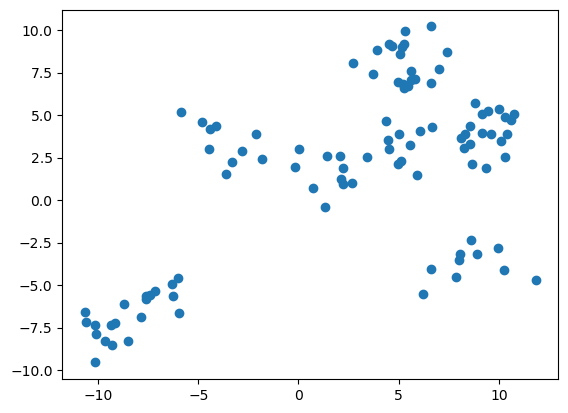

In [20]:
plt.scatter(data["col1"], data["col2"])

### Testar para os 15 Ks

In [ ]:
# alpha= 
# m0 = # media amostral
# k0 = 0.01
# nu0 = data.shape[1] + 2
# pi0 = 
# mu0k = 
# sigma0 =

for i in range(1,16):
    # s0 = 
    model = EmGMM(K= i, alpha=alpha, m0= m0, k0= k0, nu0= nu0, s0= S0, pi0 = pi0, mu0k=mu0k, sigma0= sigma0)
    model.train(X= data, epochs= 40)
    model.evaluate(data)

### Plotar o agrupamento do melhor K